# Preperation

In [1]:
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from datetime import datetime
import pytz
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import calendar
from matplotlib.patches import Ellipse


#TEST TEST

In [2]:
#Longitude of the observetory in dms
d_1=12
m_1=00
s_1=57

#Latitude of the observetory in dms
d_2=48
m_2=40
s_2=54


In [3]:
def dms_to_deg(d,m,s):
    if d == 0:
        degrees =(np.abs(d) + m/60 + s/3600)
    else:
        degrees = (np.abs(d) + m/60 + s/3600)* np.sign(d)
    return degrees

Lon = dms_to_deg(d_1,m_1,s_1)
Lat = dms_to_deg(d_2,m_2,s_2)

def deg_to_dms(degrees):
    deg=np.abs(degrees)
    d=np.round(np.floor(deg)*degrees/deg,0)
    m=np.round(np.floor(((deg-np.abs(d))*60)),0)
    s=np.round(((deg-np.abs(d)-(m/60))*3600),2)
    return d,m,s


In [4]:
def hms_to_deg(h,m,s):
    if h==0:
        degrees = 15*(np.abs(h) + m/60 + s/3600)
    else:
        degrees = 15*(np.abs(h) + m/60 + s/3600)*np.sign(h)
    return degrees

def H_to_hms(H):
    h=np.floor(H)
    m=np.floor((H-h)*60)
    s=np.round((H-h-(m/60))*3600,2)
    return h,m,s

In [5]:
def deg_to_rad(degrees):
    rad = degrees * np.pi/180
    return rad

def rad_to_deg(rad):
    degrees = rad * 180/np.pi
    return degrees


In [6]:
def earth_rotation_angle(zeit_jd):
    D_U = zeit_jd-2451545.0
    theta_0 = 360 * (0.7790572732640 + 1.00273781191135448*D_U)
    theta = theta_0 % 360
    return theta

In [7]:
def rotation_matrix_z(angles):
    if isinstance(angles, (int, float)):
        angles = [angles]
    matrices = []
    for t_p in angles:
        R_z = np.array([[np.cos(t_p), np.sin(t_p), 0],[-np.sin(t_p), np.cos(t_p), 0],[0, 0, 1]])
        matrices.append(R_z)
    return matrices

In [8]:
pi=np.pi

def rotation_matrix_y(phi):
    R_y = np.array([[np.sin(phi),0,-np.cos(phi)],[0,1,0],[np.cos(phi),0,np.sin(phi)]])
    return R_y
    
R_y=rotation_matrix_y(deg_to_rad(Lat))
diag = np.array([[-1,0,0],[0,1,0],[0,0,1]])

In [9]:
def azimut_hoehe(zeit_jd,ra_deg,dec_deg):
    ra=deg_to_rad(ra_deg)
    dec=deg_to_rad(dec_deg) 
    ERA = deg_to_rad(earth_rotation_angle(zeit_jd)) + deg_to_rad(Lon)
    R_z = rotation_matrix_z(ERA)
    R = np.array([[np.cos(ra)*np.cos(dec)],[np.sin(ra)*np.cos(dec)],[np.sin(dec)]])
    M = diag@(R_y@(R_z@R))
    H = np.arcsin(M[:,2,:])
    A = np.arctan2(M[:,1,:],M[:,0,:])
    H_deg = rad_to_deg(H)
    A_deg = rad_to_deg(A)
    return A_deg, H_deg  

In [10]:
def zenith_distance(Alltitude):
    z=90-Alltitude
    return z

In [11]:
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ra', 'dec',"flux(V)", "dim_majaxis", "dim_minaxis")

def Simbad_extraction(Objects):
    data = []

    for Object in Objects:
        result_table = custom_simbad.query_object(Object)
        if result_table is not None:
            ra_str = result_table['RA'][0]  # string in hms
            dec_str = result_table['DEC'][0]  # string in dms

            # Ensure we have three values by padding with zeros
            ra_values = list(map(float, ra_str.split())) + [0] * (3 - len(ra_str.split()))
            dec_values = list(map(float, dec_str.split())) + [0] * (3 - len(dec_str.split()))

            ra_deg = hms_to_deg(*ra_values)  # Convert RA to degrees
            dec_deg = dms_to_deg(*dec_values)  # Convert Dec to degrees

            magnitude = result_table["FLUX_V"][0] if "FLUX_V" in result_table.colnames else None
            
            if magnitude is None:
                print(f"No V-band magnitude available for '{obj}'.")
                continue

            major_axis = result_table["GALDIM_MAJAXIS"][0] if "GALDIM_MAJAXIS" in result_table.colnames else None
            
            minor_axis = result_table["GALDIM_MINAXIS"][0] if "GALDIM_MINAXIS" in result_table.colnames else None
            
            if major_axis is None or minor_axis is None:
                print(f"No size data available for '{obj}'.")
                continue

            data.append((Object, ra_deg, dec_deg, magnitude, major_axis, minor_axis))
        else:
            print(f"Object {Object} not found in Simbad.")

    return np.array(data, dtype=object)


messier_arr = np.loadtxt("Messier.txt",dtype=str)
NGC_arr = np.loadtxt("NGC.txt",dtype=str)
IC_arr = np.loadtxt("IC.txt",dtype=str) 

data_arr = np.vstack((messier_arr,NGC_arr,IC_arr))


In [40]:
fl = 750
Ap = 150
Ps = 4.30
x_ax = 5184
y_ax = 3456
Dia = np.sqrt((x_ax)**2+(y_ax)**2)

def Fov(L):
    return (206.2648 * (Ps/fl) * L)/60


FOV = Fov(Dia)


x_FOV = Fov(x_ax)
y_FOV = Fov(y_ax)

min_frac = 0.05

remove_nan = 1

def safe_convert(val):
    try:
        return float(val)
    except ValueError:
        return np.nan

def ratio(object_arr):

    maj_ax = np.array([safe_convert(x) for x in object_arr[:,4]])
    min_ax = np.array([safe_convert(x) for x in object_arr[:,5]])

    mask = (np.isnan(maj_ax) | (maj_ax>=min_frac*x_FOV)) &(np.isnan(min_ax) |  (min_ax>=min_frac*y_FOV))

    if remove_nan:
        mask = mask & ~np.isnan(maj_ax) & ~np.isnan(min_ax)

    return object_arr[mask]

data_FOV = ratio(data_arr)

def Ratio(object_row):
    Diagonal = np.sqrt(float(object_row[4])**2+float(object_row[5])**2)
    return Diagonal/FOV

In [13]:


# Alltitude maximal if ra_deg = ERA + Lambda

def min_zenith_distance(dec_deg):
    dec = deg_to_rad(dec_deg)
    phi = deg_to_rad(Lat)
    #print(phi,dec)
    H_ex_1 = np.arcsin(np.cos(phi-dec))
    #H_ex_2 = np.arcsin(np.cos(phi+dec+np.pi)+np.cos(phi-dec+np.pi))
     #np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi)+np.cos(-dec+phi)+np.cos(dec-phi)+np.cos(-dec-phi))/4)
    H_ex_2 = np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi+np.pi)+np.cos(-dec+phi+np.pi)+np.cos(dec-phi+np.pi)+np.cos(-dec-phi+np.pi))/4)
    H_EX_1 = rad_to_deg(H_ex_1)
    H_EX_2 = rad_to_deg(H_ex_2)
    #print(H_EX_1,H_EX_2)
    if H_ex_1 > H_ex_2:
        z = zenith_distance(H_EX_1)
    else:
        z = zenith_distance(H_EX_2)
    return z

#arcsin((-2*cos(dec+phi)+2*cos(dec-phi)+cos(dec+phi+pi)+cos(-dec+phi+pi)+cos(dec-phi+pi)+cos(-dec-phi+pi))/4)

min_zen_dis = []

for n in range(len(data_FOV[:,1])):
    z = min_zenith_distance(data_FOV[n,2].astype(float))
    min_zen_dis.append(z)
Z_s = np.array(min_zen_dis)

#deleting all Objects which never reach 60° 

indices_to_del = []

for n in range(len(Z_s)):
    if float(Z_s[n].item()) >40:
        indices_to_del.append(n)
Z_g = np.delete(Z_s,indices_to_del,0)
#print(Z_g)
data_min_h = np.delete(data_FOV, indices_to_del,0)




# Time

In [14]:
#according to timeanddate.de the night of the September 11th 2024 in Bamberg starts at 21:30 and goes on till 4:55. Thus the night is 7h 25m long
#print(data_min_h)
delta_T = 8/24
p = int(delta_T*1440 + 1)
print("t:" ,delta_T)
#Number of minutes in delta_t is 445

T = np.linspace(0,delta_T,p)

#deleting all Objects from the array which have an Elevation of 30° for less than 2 hours of the 1st Praktikum night 



# Example datetime in CEST (Central European Summer Time)
cest_tz = pytz.timezone('Europe/Berlin')  
dt = datetime(2025, 3, 1, 19, 0, 0)  

# Localize the datetime to CEST timezone
cest_time = cest_tz.localize(dt)

# Convert to UTC, since Julian Date is based on UTC
utc_time = cest_time.astimezone(pytz.utc)
print("time",utc_time) 

# Use astropy to get Julian Date
Zeit_Nacht = Time(utc_time).jd
print(Zeit_Nacht)

Zeit_Nacht_T = Zeit_Nacht + T
keep = []
more_del=[]
num = 120
m = 30

for n in range(len(data_min_h[:,0])):
    if np.sum((azimut_hoehe(Zeit_Nacht_T,data_min_h[n,1].astype(float),data_min_h[n,2].astype(float)))[1] > m) >=num:
        keep.append(n) 
    else: 
        more_del.append(n)

data_fin = np.delete(data_min_h,more_del,0)

minutes = np.linspace(0,p,p)
start_time = datetime.strptime("19:00", "%H:%M")
time_data = [start_time + timedelta(minutes=int(minute)) for minute in minutes]

#Printing the resulting list and Plotting the Elevation in relation to the time on the night of the 1st day of the Praktikum

print('Objects which fit all Criterea:', ', '.join(map(str,data_fin[:,0])))


t: 0.3333333333333333
time 2025-03-01 18:00:00+00:00
2460736.25
Objects which fit all Criterea: M1, M3, M13, M34, M35, M36, M37, M38, M44, M45, M51, M52, M53, M58, M59, M60, M63, M64, M66, M67, M81, M84, M85, M86, M87, M88, M89, M90, M91, M92, M94, M95, M96, M99, M100, M101, M103, M105, M106, NGC103, NGC129, NGC146, NGC188, NGC189, NGC225, NGC381, NGC433, NGC436, NGC457, NGC559, NGC581, NGC654, NGC659, NGC663, NGC743, NGC744, NGC752, NGC869, NGC884, NGC886, NGC925, NGC957, NGC1027, NGC1039, NGC1245, NGC1333, NGC1342, NGC1348, NGC1444, NGC1502, NGC1513, NGC1528, NGC1545, NGC1579, NGC1582, NGC1605, NGC1647, NGC1662, NGC1664, NGC1708, NGC1724, NGC1750, NGC1758, NGC1778, NGC1807, NGC1817, NGC1857, NGC1893, NGC1907, NGC1912, NGC1931, NGC1952, NGC1960, NGC2099, NGC2126, NGC2129, NGC2141, NGC2158, NGC2168, NGC2169, NGC2192, NGC2194, NGC2224, NGC2234, NGC2264, NGC2265, NGC2266, NGC2281, NGC2355, NGC2395, NGC2403, NGC2420, NGC2632, NGC2678, NGC2682, NGC2841, NGC2903, NGC2905, NGC3031, NGC3180, 

# Advanced Viewer

In [36]:
data_30 = []

for n in range(len(data_fin[:,0])):
    N = np.sum((azimut_hoehe(Zeit_Nacht_T,data_fin[n,1].astype(float),data_fin[n,2].astype(float)))[1] > m)
    data_30.append(N) 

data_30_arr = np.array(data_30, dtype = float)


sorted_data_30 = np.append(data_fin, data_30_arr[:, None], axis=1)


final_best = np.array(sorted(sorted_data_30, key=lambda x: ( float(x[6]), float(x[4])), reverse=True),dtype = object)



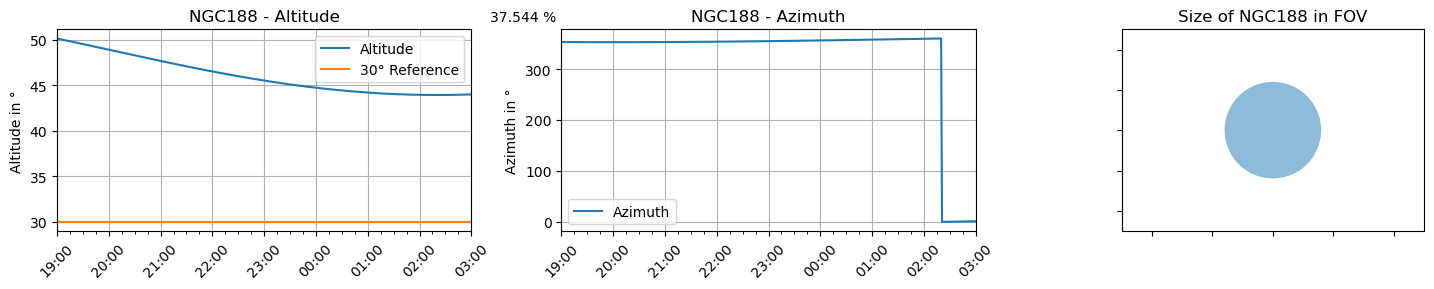

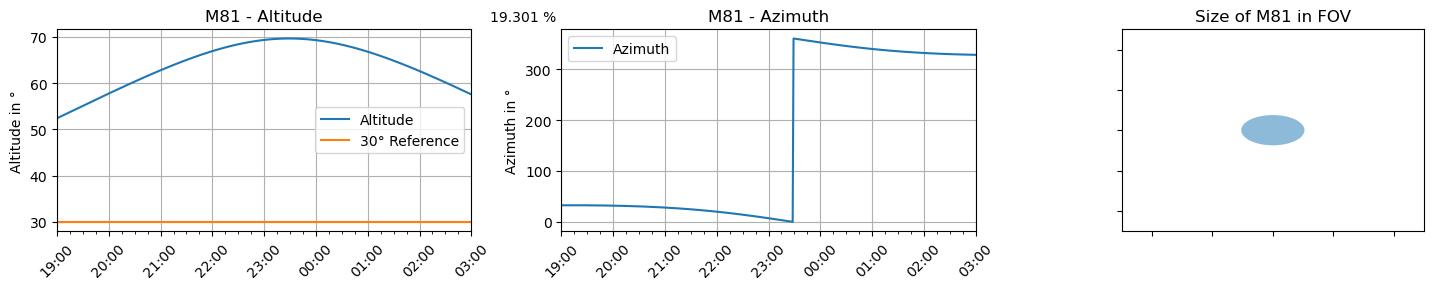

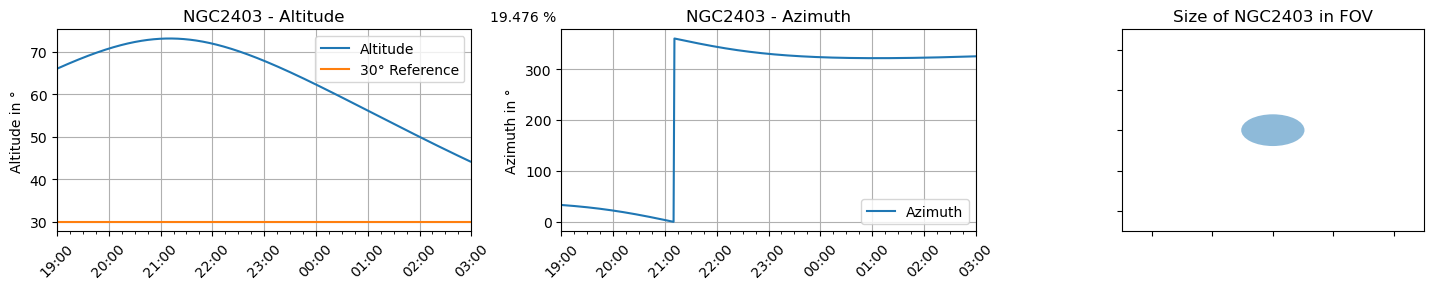

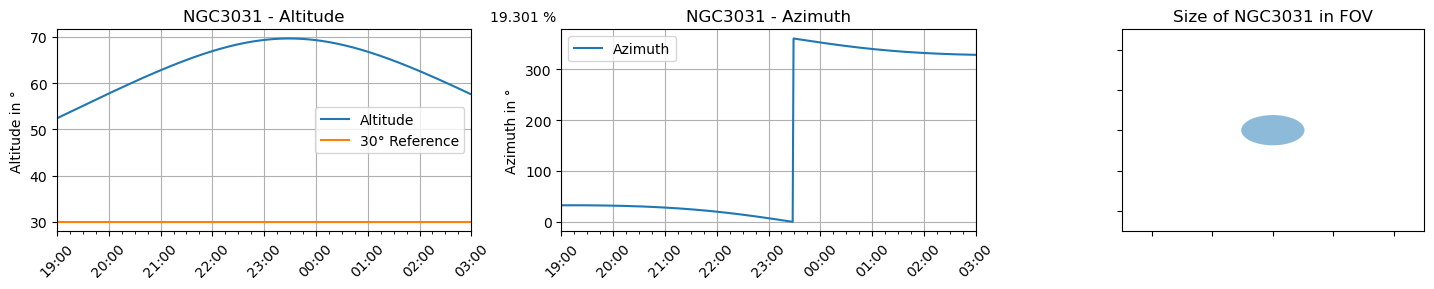

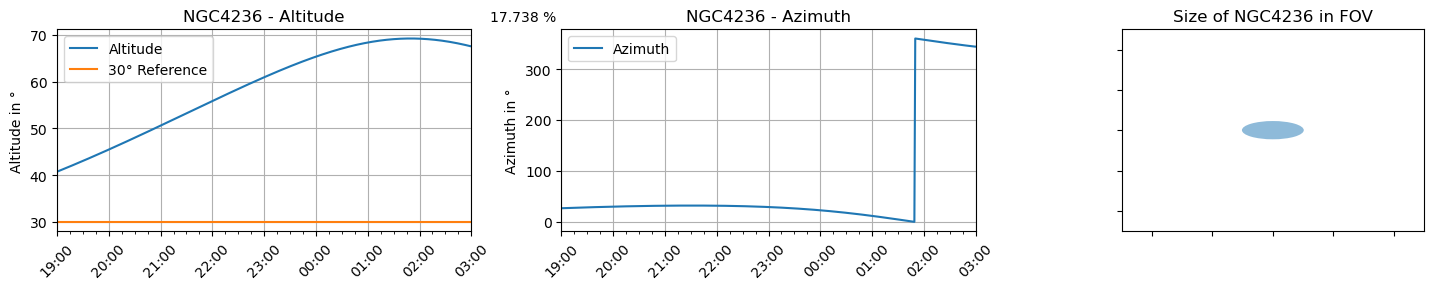

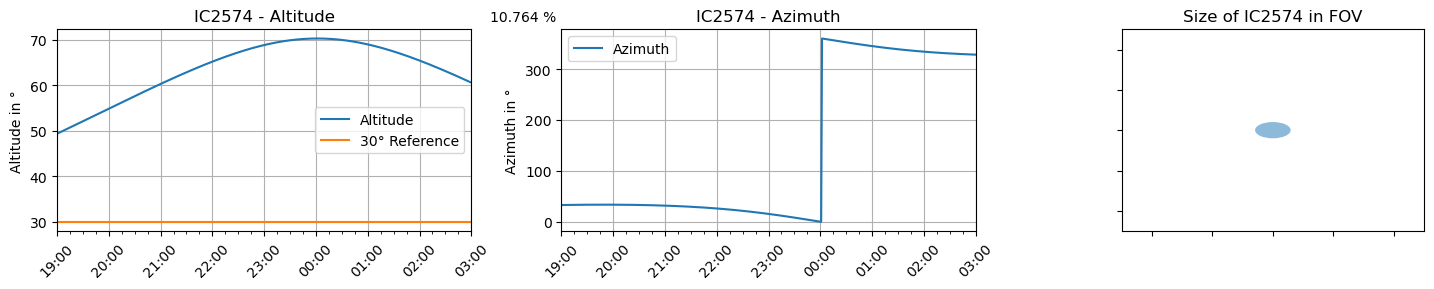

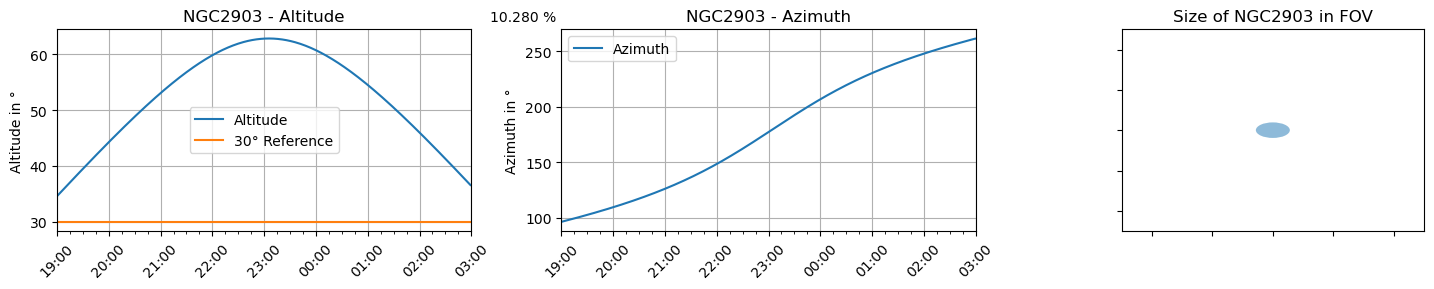

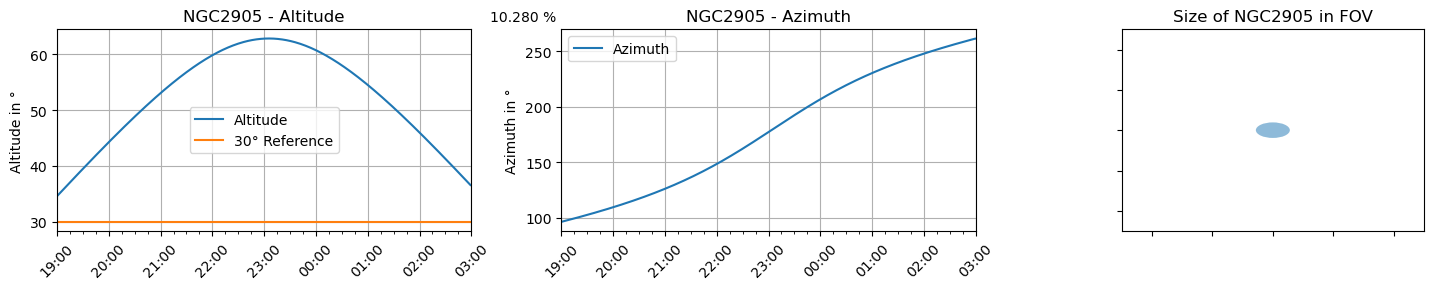

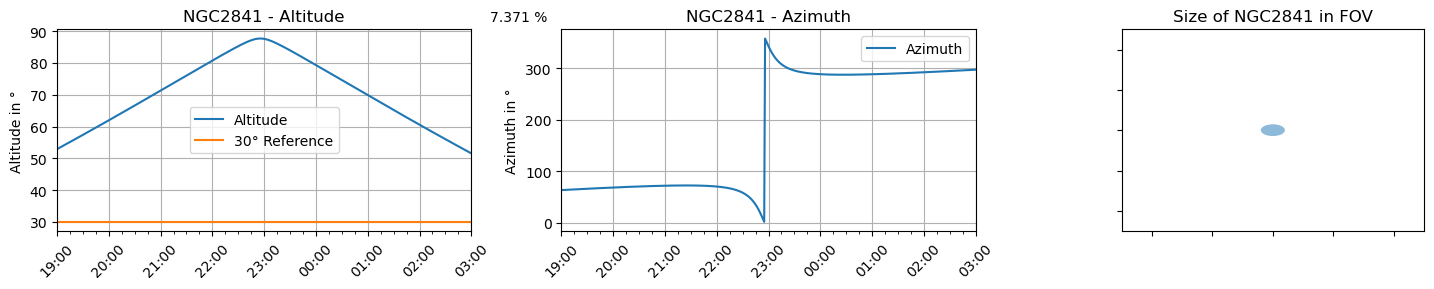

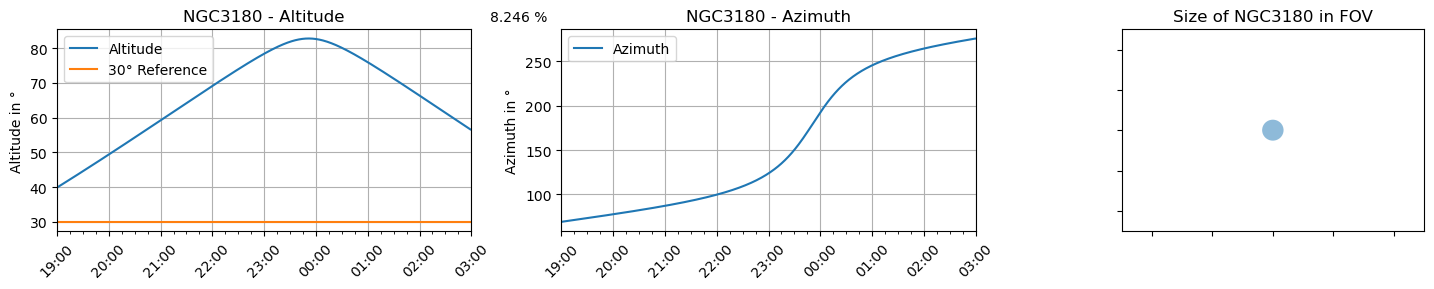

In [41]:
k = 10
k_max = len(final_best[:,0])

for n in range(k):
    H = (azimut_hoehe(Zeit_Nacht_T,float(final_best[n,1]),float(final_best[n,2])))[1]
    a = (azimut_hoehe(Zeit_Nacht_T,float(final_best[n,1]),float(final_best[n,2])))[0]
    A=[x + 360 if x<0 else x for x in a]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
   # Plot Altitude (H) on the first axis
    ax1.plot(time_data, H, label='Altitude')
    ax1.plot(time_data, np.linspace(30, 30, p), label='30° Reference')
    ax1.set_title(f"{final_best[n, 0]} - Altitude")
    ax1.set_ylabel('Altitude in °')
    ax1.set_xlim(datetime.strptime("19:00", "%H:%M"), datetime.strptime("03:00", "%H:%M") + timedelta(days=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax1.legend()
    ax1.grid()

    
    
     # Plot Azimuth (A) on the second axis
    ax2.plot(time_data, A,"-",label='Azimuth')
    #ax2.plot(time_data, np.linspace(30, 30, len(time_data)), label='30° Reference')
    ax2.set_title(f"{final_best[n, 0]} - Azimuth")
    ax2.set_ylabel('Azimuth in °')
    ax2.set_xlim(datetime.strptime("19:00", "%H:%M"), datetime.strptime("03:00", "%H:%M") + timedelta(days=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax2.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax2.legend()
    ax2.grid()



    ellipse = Ellipse((0,0),width=float(final_best[n,4])/x_FOV,height=float(final_best[n,5])/y_FOV,angle = 0, alpha = 0.5)


    ax3.add_patch(ellipse)

    ax3.set_xlim(-0.5,0.5)
    ax3.set_ylim(-0.5,0.5)
    ax3.set_title(f"Size of {final_best[n,0]} in FOV")
    ax3.set_aspect(aspect=y_ax/x_ax)

    ax3.set_xticklabels([])
    ax3.set_yticklabels([])

    # Rotate x-axis labels for both plots
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    fig.text(0.33,0.91,f"{np.float64(Ratio(final_best[n]))*100:.3f} %")
    # fig.text(0.46,0.91,f"{np.float64(surface_brightness_list[n,1]):.2f} mag/arcmin^2" )
    # Show the plots
    plt.tight_layout()
    plt.show()
    #fig.savefig(data_fin[n,0].pdf,dpi=300)

# Time Viewer

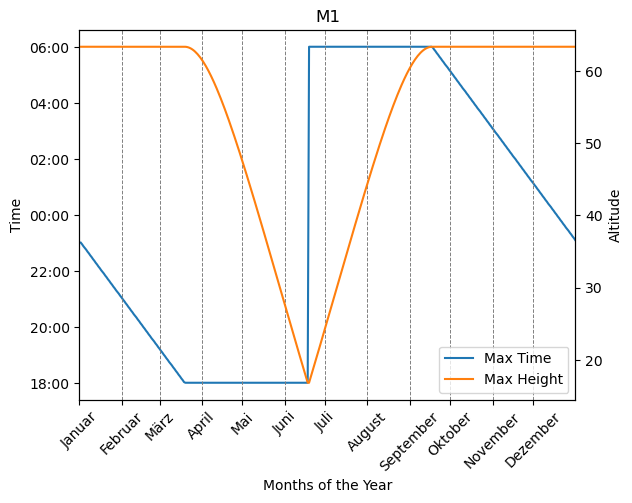

In [38]:
object_map = {name: idx for idx, name in enumerate(data_arr[:, 0])}

def get_row_by_name(name):
    """Get the row index for a given object name."""
    return object_map.get(name, None)


dt_1 = datetime(2025, 1, 1, 18, 0, 0)  
cest_tz = pytz.timezone("Europe/Berlin")  
cest_time_1 = cest_tz.localize(dt_1)

utc_time_1 = cest_time_1.astimezone(pytz.utc)
# print("utc time", utc_time_1)

# Use astropy to get Julian Date
Zeit_start = Time(utc_time_1).jd
# print(Zeit_start)

day_arr = np.linspace(0, 0.5, 1001)
max_time = []
max_height = []


object_name = "M1"  # Replace with the desired name
object_idx = get_row_by_name(object_name)

if object_idx is not None:
    for n in range(365):
        Day = Zeit_start + day_arr + n
        H_object = (azimut_hoehe(Day, data_arr[object_idx, 1].astype(float), data_arr[object_idx, 2].astype(float)))[1]
        max_time_loop = np.argmax(H_object)
        max_loop = np.max(H_object)
        max_height.append(max_loop)
        time_loop = np.linspace(0, 12, 1001)[max_time_loop]
        max_time.append(time_loop)

    max_time_arr = np.array(max_time)
    max_height_arr = np.array(max_height)
    year = np.linspace(1, 365, 365)

    def convert_time(value):
        """Converts time (0-12) to 18:00-6:00 format."""
        hours = (value + 18) % 24
        return f"{int(hours):02d}:00"

    month_days = [0] + np.cumsum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]).tolist()
    month_labels = [calendar.month_name[i] for i in range(1, 13)]

    # Plotting
    fig, ax1 = plt.subplots()
    line1, = ax1.plot(year, max_time_arr, color='#1f77b4', label="Max Time")
    ax1.set_ylabel("Time")
    ax1.set_xlabel("Months of the Year")
    ax1.set_xlim(0,365)
    ax1.set_title(object_name)

    ax1.set_yticks(np.linspace(0, 12, 7))  
    ax1.set_yticklabels([convert_time(tick) for tick in np.linspace(0, 12, 7)])  

    ax1.set_xticks(month_days[:-1])  
    ax1.set_xticklabels(month_labels)

    for day in month_days[1:-1]:  # Skip the first (0) and last (end of the year)
        ax1.axvline(x=day, color='gray', linestyle='--', linewidth=0.7)

    ax2 = ax1.twinx()
    line2, = ax2.plot(year, max_height_arr, color='#ff7f0e', label="Max Height")
    ax2.set_ylabel("Altitude")


    # ax1.set_ylim(-0.5,12.5)
    # ax2.set_ylim(0,90)


    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc="lower right")  
    plt.show()
else:
    print(f"Object '{object_name}' not found in data.")


# Map

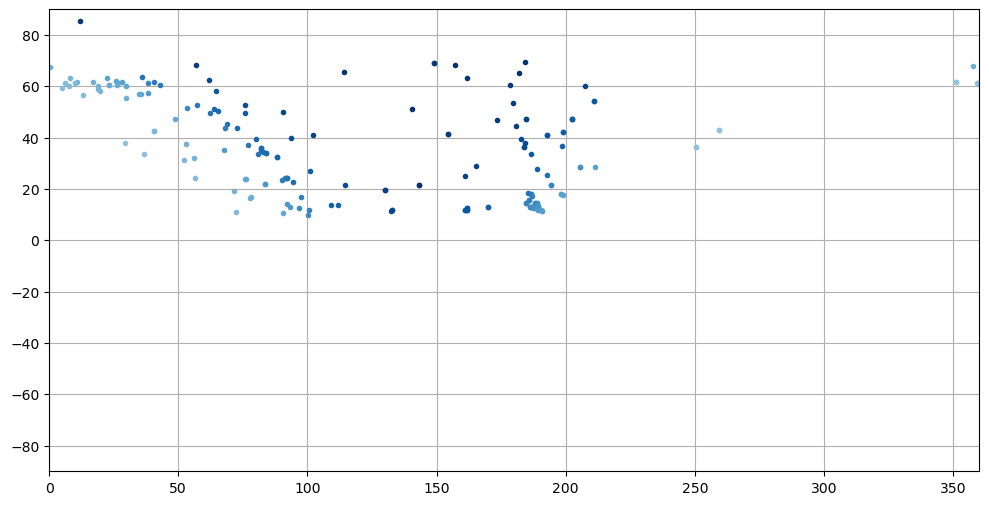

In [ ]:
def maping(objects):
    
    fig,ax = plt.subplots(figsize=(12,6))

    num_points = len(objects)  
    colors = plt.cm.Blues(np.linspace(1, 0.4, num_points))  
    

    for n in range(num_points):
        ax.plot(
            float(objects[n, 1]), 
            float(objects[n, 2]), 
            ".", 
            color=colors[n], 
            label=objects[n, 0] if n < 10 else ""  
        )


    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.grid()
    plt.show


maping(final_best)

